In [815]:
# Sorta like jpeg 2000 but simpler

In [1]:
# Import functions and libraries
%pylab
import numpy as np
import matplotlib.pyplot as plt
import pyaudio, Queue, threading,time, sys, threading,time, serial
from __future__ import division
from numpy import pi, sin, zeros, r_
from scipy import signal
from rtlsdr import RtlSdr
from scipy import misc
import cPickle as pickle

import bitarray, time, urllib, ssl
from scipy import signal, integrate
from fractions import gcd

import pywt

# import ax25

# # # Serialize object
# f = open('pick_name.pickle', 'wb')
# pickle.dump(NN, f, protocol=pickle.HIGHEST_PROTOCOL)
# f.close()

# Load object
# f = open('picked_name.pickle', 'rb')
# Y = pickle.load(f)
# f.close()

%matplotlib inline
# %pylab

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [95]:
plt.rcParams['figure.figsize'] = (12, 8) # (16, 16) # (6, 4) for normal size

## TODO

In [2]:
    # rounding when quantizing
    
    # run-length encoding of thresh + quantized result(compress coefficients (lossless))
    
    # add back bit depth to img
        
    # look into more jpeg 2000 shit
    
    # dealing with color images: chroma subsampling, YCrCb
    
    # zero-padding all the way out to the next power of 2 unneccessary: can be fine
        # with only padding so that power of 2 tiles of size tile_size fit (since we are taking dwt of tiles)
        
    # TRANSMIT THRESHED + QUANTIZED + COMPRESSED DWT COEFFS AND RECONSTRUCT IMG FROM RECEIVED SIGNAL

## END TODO

In [339]:
# Compression functions

def compress_bw(im, tile_size, fraction_coeffs, wvlt='db4'):
    
    # DC Level Shift
    im, bit_depth = subtract_bit_depth(im)
    
    # Makes tiling easier (but don't need dimension to be next power of 2)
    transformed = map_image_to_square(im)
    
    # Partition into tiles
    partition = image2tile_partition(transformed, tile_size)
    
    # Compute dwt on each tile
    dwt_tiling = dwt_tiles(partition, wvlt=wvlt)
    
    # Compress dwt coeffs
    thresh_tiles = thresh_dwt(dwt_tiling, f = fraction_coeffs)

    # Quantize coeffs (these can be transmitted to reconsxt image later)
    thresh_tiles = np.round(thresh_tiles, 0)
    thresh_tiles = np.int32(thresh_tiles)
    
    return thresh_tiles, bit_depth
    
def decompress_bw(thresh_tiles, original_shape, original_bit_depth, wvlt='db4'):
    # inverse of the above
    idwts = tile_idwt(thresh_tiles, wvlt=wvlt)
    idwts_img = tile_partition2image(idwts)
    # if original_bit_depth = 8 (ie img 0-255 values) then add 2**7 because we sub'd 2**7 before.
    compressed_img = map_square_to_original(idwts_img, original_shape) + 2**(original_bit_depth-1)
    return compressed_img

# Without tiling:

def compress_notile(image, fraction_coeffs, wvlt='db4'):
    # compress an image save the largest fraction_coeffs dwt coeffs. (does not do tiling, directly threshes all coeffs)
    square, orig_bit_depth = subtract_bit_depth(map_image_to_square(image))
    dwt_square = dwt2(square, 1, wvlt=wavelet)
    thresh_dwt_coeffs = thresh_dwt(dwt_square, f = fraction_coeffs)
    
    # Quantize coeffs (these can be transmitted to reconsxt image later)
    compressed_dwt = np.int32(np.round(thresh_dwt_coeffs, 0))
    
    return compressed_dwt, orig_bit_depth

def decompress_notile(compressed_dwt, original_shape, original_bit_depth, wvlt='db4'):
    # inverse of compress_notile
    idwt_square = idwt2(compressed_dwt, 1, wvlt=wavelet)
    decompressed_img = map_square_to_original(idwt_square, im.shape) + 2**(original_bit_depth-1)
    return decompressed_img

In [340]:
# Utility functions

def rgb2gray(img):
    # converts RGB img into 1 channel
    # mainly for testing
    return np.dot(img[...,:3], [0.299, 0.587, 0.114])

def num_nonoverlap_tiles(shape, tile_size):
    # shape: image shape, (rows, cols), rows and cols both must be at least tile_size**2.
    # tile_size: number of pixels in an edge of a tile. must be power of 2.
    # returns: num tiles that fit image with shape shape without overlap
    assert log(tile_size)/log(2) % 1 == 0, 'Tile size must be a power of 2.'
    rows, cols = shape
    assert rows >= tile_size and cols >= tile_size, 'Tile size too large.'
    horiz = rows//tile_size
    vert = cols//tile_size
    return horiz, vert

def subtract_bit_depth(image):
    # Level shift: (helps with getting chains of zeros in DWT)
    bit_depth = log(image.max()-1)/log(2)//1 + 1
    image = image - 2**(bit_depth-1)
    return image, bit_depth

def bit_depth_to_add(image):
    bit_depth = log(image.max()-1)/log(2)//1
    return bit_depth

def map_image_to_square(image):
    # map the original image to a power of two.
    larger = max(image.shape)
    largest_power = log(larger)//log(2)
    # check if image is already a power of two.
    if 2**largest_power == larger and image.shape[0] == image.shape[1]: 
        return image
    else:
        next_power_of_2 = largest_power + 1
    new_image = np.zeros((2**next_power_of_2,2**next_power_of_2))
    new_image[:image.shape[0],:image.shape[1]] = image
    return new_image

def map_square_to_original(image, shape):
    # map back to the original image.
    # inverse of map_image_to_square
    original = np.zeros(shape)
    original = image[:shape[0],:shape[1]]
    return original

def image2tile_partition(image, tile_size):
    # only works for square images with dimension a power of 2
    # tile_size must also be a power of 2.
    # returns list of tiles
    # goes top to bot, l to r.
    assert image.shape[0] == image.shape[1]
    tiles = []
    for i in range(int(image.shape[0]/tile_size)):
        for j in range(int(image.shape[1]/tile_size)):
            tiles += [image[i*tile_size:(i+1)*tile_size,j*tile_size:(j+1)*tile_size]]
    return np.array(tiles)

def tile_partition2image(tiles):
    # the inverse of image2tile_partition
    # num pixels in tiles must be a power of 2.
    pixels = tiles.shape[0]*tiles.shape[1]*tiles.shape[2]
    side_length = int(sqrt(pixels))
    num_tiles = len(tiles)
    tile_size = tiles.shape[1]
    tiles_on_edge = int(side_length/tile_size)
    image = np.zeros((side_length, side_length))
    
    for t in range(len(tiles)):
        image[(t // tiles_on_edge)*tile_size : (t // tiles_on_edge + 1)*tile_size, \
               (t % tiles_on_edge)*tile_size : (t % tiles_on_edge + 1)*tile_size] = tiles[t]
    return image

def dwt_tiles(tiles, wvlt='db4'):
    # single level db4 wt on each tile.
    dwts = []
    for tile in tiles:
        dwts += [dwt2(tile, 1, wvlt=wvlt)]
    return np.array(dwts)

def thresh_dwt(dwt_tiles, f):
    # f: the fraction f largest wavelet coeffs (to save)
    # parts borrowed from hw9
    # used with the output of dwt_tiles(...)
    thresh_tiles = []
    for tile in dwt_tiles:
        m = np.sort(abs(tile.ravel()))[::-1]
        idx = int(len(m) * f) # the fraction f largest wavelet coeff.
        thr = m[idx] # thr
        thresh_tiles += [tile * (abs(tile) > thr)]
    return np.array(thresh_tiles)

def tile_idwt(tiles, wvlt='db4'):
    idwts = []
    for tile in tiles:
        idwts += [idwt2(tile, wvlt=wvlt)]
    return np.array(idwts)

def show_dwt_tiles(image, tile_size, im_title='DWT tiles', wvlt='db4'):
    # used for showing dwt tiles of original, uncompressed images. 
    tiles = dwt_tiles(image2tile_partition(map_image_to_square(subtract_bit_depth(image)[0]), tile_size), wvlt=wvlt)
    figure()
    title(im_title)
    imshow(tile_partition2image(tiles), cmap = 'gray')
    return tiles

In [341]:
# Resources: HW9, 
#            http://faculty.gvsu.edu/aboufade/web/wavelets/student_work/ef/how-works.html,
#            http://www.dmi.unict.it/~battiato/EI_MOBILE0708/JPEG2000%20(Bruna).pdf

In [342]:
# This cell contains functions borrowed from hw9.

def imshowgray(im, vmin=None, vmax=None):
    plt.imshow(im, cmap=plt.get_cmap('gray'), vmin=vmin, vmax=vmax)

def wavMask(dims, scale):
    sx, sy = dims
    res = np.ones(dims)
    NM = np.round(np.log2(dims))
    for n in range(int(np.min(NM)-scale+2)//2):
        res[:int(np.round(2**(NM[0]-n))), :int(np.round(2**(NM[1]-n)))] = \
            res[:int(np.round(2**(NM[0]-n))), :int(np.round(2**(NM[1]-n)))]/2
    return res

def imshowWAV(Wim, scale=1):
    plt.imshow(np.abs(Wim)*wavMask(Wim.shape, scale), cmap = plt.get_cmap('gray'))

def coeffs2img(LL, coeffs):
    LH, HL, HH = coeffs
    return np.vstack((np.hstack((LL, LH)), np.hstack((HL, HH))))

def unstack_coeffs(Wim):
        L1, L2  = np.hsplit(Wim, 2) 
        LL, HL = np.vsplit(L1, 2)
        LH, HH = np.vsplit(L2, 2)
        return LL, [LH, HL, HH]

def img2coeffs(Wim, levels=4):
    LL, c = unstack_coeffs(Wim)
    coeffs = [c]
    for i in range(levels-1):
        LL, c = unstack_coeffs(LL)
        coeffs.insert(0,c)
    coeffs.insert(0, LL)
    return coeffs
    
def dwt2(im, level=1, wvlt='db4'):
    coeffs = pywt.wavedec2(im, wavelet=wvlt, mode='per', level=level)
    Wim, rest = coeffs[0], coeffs[1:]
    for levels in rest:
        Wim = coeffs2img(Wim, levels)
    return Wim

def idwt2(Wim, levels=1, wvlt='db4'):
    coeffs = img2coeffs(Wim, levels=levels)
    return pywt.waverec2(coeffs, wavelet=wvlt, mode='per')

In [343]:
image = misc.imread('imgs/dude.bmp') # load an image
# plt.imshow(image)
# plt.title('Show color image')

im = rgb2gray(image) # convert to grayscale

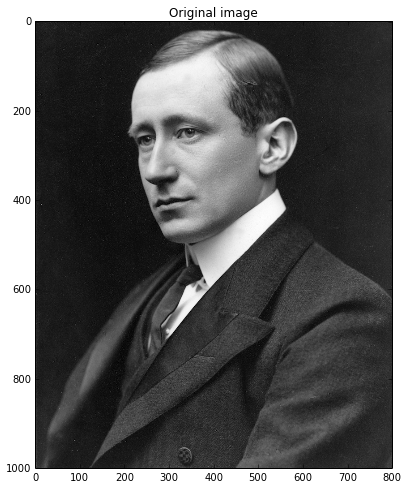

In [344]:
title('Original image')
imshow(im, cmap = 'gray')

In [345]:
original = np.copy(im)

In [346]:
tile_size = 32
fraction_coeffs = 0.25
wavelet = 'bior3.7'
tiles, orig_bit_depth = compress_bw(im, tile_size, fraction_coeffs, wvlt=wavelet)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:38: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


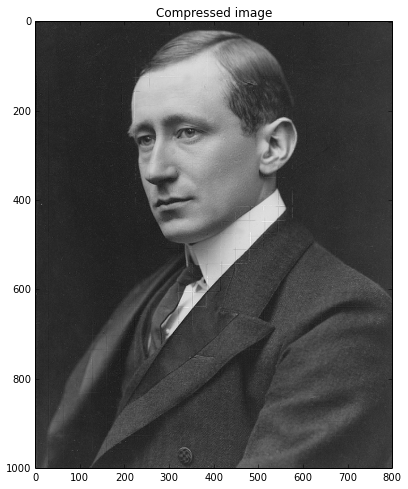

In [347]:
compressed_img = decompress_bw(tiles, im.shape, orig_bit_depth, wvlt=wavelet)

title('Compressed image')
imshow(compressed_img, cmap = 'gray')

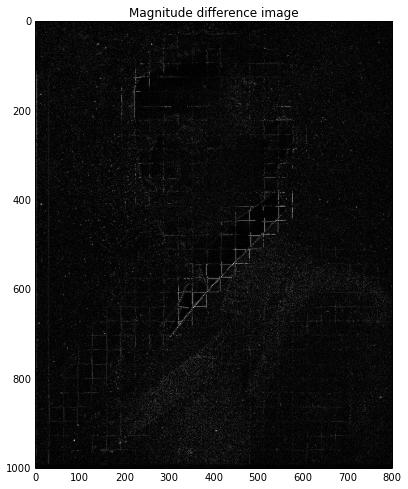

In [348]:
title('Magnitude difference image')
imshow(abs(compressed_img - original), cmap = 'gray')

# orig_tiles = show_dwt_tiles(im, tile_size, 'Original DWT tiles', wvlt=wavelet);

# title('Compressed DWT tiles')
# tiles_img = tile_partition2image(tiles)
# imshow(tiles_img, cmap = 'gray')

In [349]:
# Without tiling: direct thresh of dwt coeffs on whole image

In [350]:
_fraction = 0.5
_wavelet = 'bior4.4'

dwt_notile, og_bitdepth = compress_notile(im, _fraction, wvlt=_wavelet)
cmprsd_notile = decompress_notile(dwt_notile, im.shape, og_bitdepth, wvlt=_wavelet)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:38: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


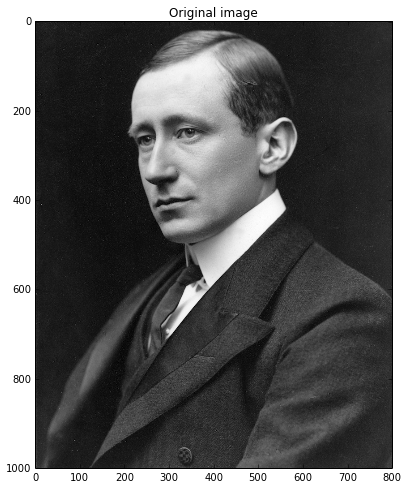

In [351]:
title('Original image')
imshow(original, cmap='gray')

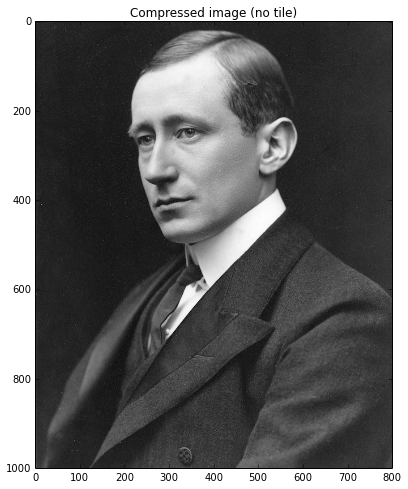

In [352]:
title('Compressed image (no tile)')
imshow(cmprsd_notile, cmap='gray')

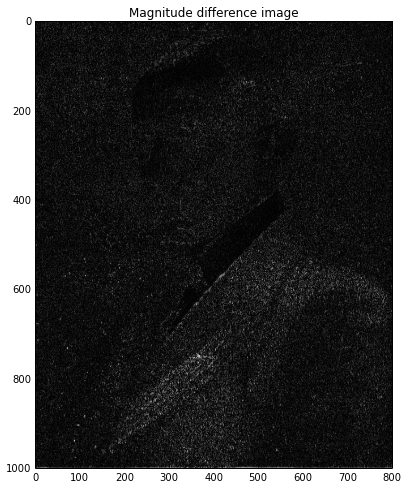

In [353]:
title('Magnitude difference image')
imshow(abs(cmprsd_notile - original), cmap = 'gray')

In [355]:
# Run-length encoding below (lossless data compression)
    # on each tile? or on compressed img?
    # certainly longer chains on compressed img, but what about errors?
        # well, we can tile the run length encoded stuff, too...